# Music tagging Transformer
This file traines a transformer from the melspectogram features


In [1]:
import json
import yaml
from pathlib import Path
from lib_util import utils, plot, transformer_utils

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import (
    Input,
    GlobalAvgPool1D,
    Dense,
    Dropout,
)
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.models import Model, load_model
from keras.optimizers import Adam
import keras.utils


from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import clip_ops

%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-01-15 19:40:54.452249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define crossentropy and accuracy metric for the training routine
For the metric we use a binary accuracy, for the loss a binary cross-entropy loss

## Define model
Define the transformer model structure with the Encoder from the transformer util file.

In [2]:
def transformer_model(model_config, n_classes):
    """Transformer model where the model will be trained on the training data
    """
    num_layers = model_config['n_layers']
    d_model = model_config['d_model']
    num_heads = model_config['n_heads']
    dff = model_config['dff']
    maximum_position_encoding = model_config['max_pos_encoding']
    init_lr = model_config['init_learning_rate']
    dropout_rate = model_config['dropout_rate']
    activations = model_config['activations']

    input_layer = Input((None, d_model))
    #Getting the encoder code from the transformer
    encoder = transformer_utils.Encoder(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        maximum_position_encoding=maximum_position_encoding,
        rate=model_config['encoder_rate']
    )

    x = encoder(input_layer)
    x = Dropout(dropout_rate)(x)
    x = GlobalAvgPool1D()(x)
    x = Dense(4 * n_classes, activation=activations[0])(x)

    out = Dense(n_classes, activation=activations[1])(x)

    loss = BinaryCrossentropy(
        name='binary_crossentropy'
    )
    
    metric = BinaryAccuracy(
        name='binary_accuracy'
    )

    model = Model(inputs=input_layer, outputs=out)
    model.compile(optimizer=Adam(init_lr), loss=loss, metrics=metric)
    model.summary()
    return model


# Main routine
## Load the configuration for this model

In [3]:
config = utils.get_config('transformer')

# Extract the values
transformer_name = config['transformer_name']
batch_size = config['batch_size']
epochs = config['epochs']
data_dir = Path(config['data_dir'])

## Load preprocessed data
Load the numpy arrays and the label-class mapping. Split the data accordingly into train, validation and test set

In [4]:
melspec_data = utils.load_sliced_numpy_array('melspec_features', data_dir=data_dir)
labels = np.load(data_dir/'labels.npy')

with open(data_dir/'class_label_index_mapping.json', 'r') as f:
    labels_to_id = json.load(f)

mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=config['train_set_size'], random_state=config['random_state'])
mel_val, mel_test, lab_val, lab_test             = train_test_split(mel_test_val, lab_test_val, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]

def normalization(mel_train, mel_test, mel_val):
    """Normalize the data files by dividing every data point by the maximum of the train data set
    """
    maximum = np.amax(mel_train)
    mel_train = mel_train/maximum
    mel_test = mel_test/maximum
    mel_val = mel_val/maximum
    return (mel_train.astype(np.float32), mel_test.astype(np.float32), mel_val.astype(np.float32))

mel_train_n, mel_test_n, mel_val_n = normalization(mel_train, mel_test, mel_val)

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)


## Set up the model callbacks
For the initializing parameters, refer to the config file.  
For callbacks, we use a frequently backup of the model as checkpoints, and early stopping mechanism to prevent overfitting on the training data and a learningrate reducer, that smallers the update steps when the validation metric does not improve any more

In [5]:
train_config = config['training']

checkpoint = ModelCheckpoint(
    f'models/{transformer_name}_checkpoint',
    monitor=train_config['monitor'],
    verbose=1,
    save_best_only=train_config['save_best_weights'],
    mode=train_config['monitor_mode'],
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 7,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True,
    start_from_epoch = 3
)

# Reduce learning rate when val_loss stopps improving
lr_reduce_config = train_config['lr_reducing']
lr_reducing_on_platteau = ReduceLROnPlateau(
    monitor=lr_reduce_config['monitor'],
    patience=lr_reduce_config['patience'],
    min_lr=lr_reduce_config['min_lr'],
    mode=lr_reduce_config['mode']
)

## Train routine

In [6]:
pp_config = utils.get_config('preprocess')

n_mels = pp_config['melspectogram']['n_mels']
mel_train_n = mel_train_n.reshape(mel_train_n.shape[0], -1, n_mels)
mel_val_n   = mel_val_n.reshape(mel_val_n.shape[0], -1, n_mels)
mel_test_n   = mel_test_n.reshape(mel_test_n.shape[0], -1, n_mels)

model = transformer_model(config['model_structure'], n_classes=len(labels_to_id))

history = model.fit(
        x=mel_train_n,
        y=lab_train,
        validation_data=(mel_val_n, lab_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint, lr_reducing_on_platteau, early_stopping],
        use_multiprocessing=True,
        verbose=2
    )


2023-01-15 19:41:24.991316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1134, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 311, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2062, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.

KeyboardInterrupt: 

dump the history to file

In [82]:
to_dump = {
    'model': model,
    'history': history,
    'config': config
}

utils.save_training(to_dump, transformer_name)

INFO:tensorflow:Assets written to: models/music_tagging_transformer_trained/assets


INFO:tensorflow:Assets written to: models/music_tagging_transformer_trained/assets


Evaluate the training history

available keys dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])


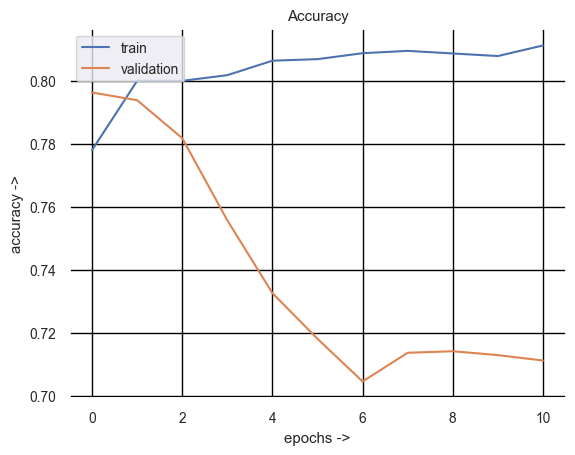

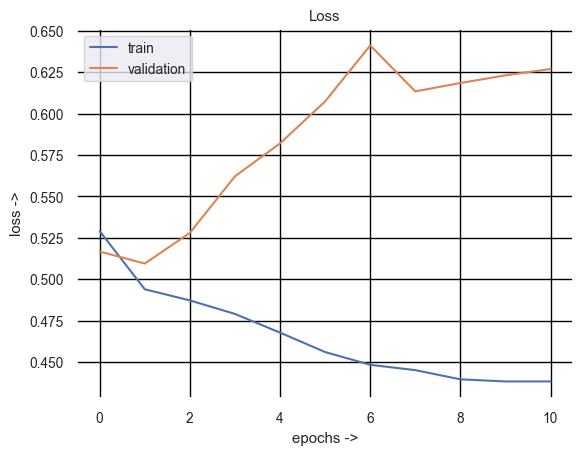

In [83]:
history_dict = utils.load_history(transformer_name)

print('available keys', history_dict.keys())

#Plots for the accuracies and losses of the train and validation data per epoch
plot.plot_hist(history_dict, ('binary_accuracy', 'val_binary_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/short_chunk_cnn_{epochs}_acuracy')
plot.plot_hist(history_dict, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/short_chunk_cnn_{epochs}_loss')

Predict model output on all the available sets

In [89]:
predict = lambda model, data: np.argmax(model.predict(data), axis=-1)

#custom_objects = {"Encoder": Encoder}
#with keras.utils.custom_object_scope(custom_objects):
    #new_model = keras.Model.from_config(config)
    #Loading in the model
# model = utils.load_model(transformer_name)

# Training prediction
y_pred_train = predict(model, mel_train_n)
y_true_train = np.argmax(lab_train, axis= -1)
print(f"ACCURACY FOR TRAIN SET {accuracy_score(y_true_train, y_pred_train)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='micro')*100:.4f} %")

# Validation prediction
y_pred_val = predict(model, mel_val_n)
y_true_val = np.argmax(lab_val, axis= -1)
print(f"ACCURACY FOR VAL SET {accuracy_score(y_true_val, y_pred_val)*100:.4f} %")
print(f"MACRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='micro')*100:.4f} %")

# Test prediction
y_pred_test = predict(model, mel_test_n)
y_true_test = np.argmax(lab_test, axis= -1)
print(f"ACCURACY FOR TEST SET {accuracy_score(y_true_test, y_pred_test)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='micro')*100:.4f} %")

77/77 [==============================] - 43s 555ms/step


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1134, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 311, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2062, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2098, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

# Plot confusion matrix

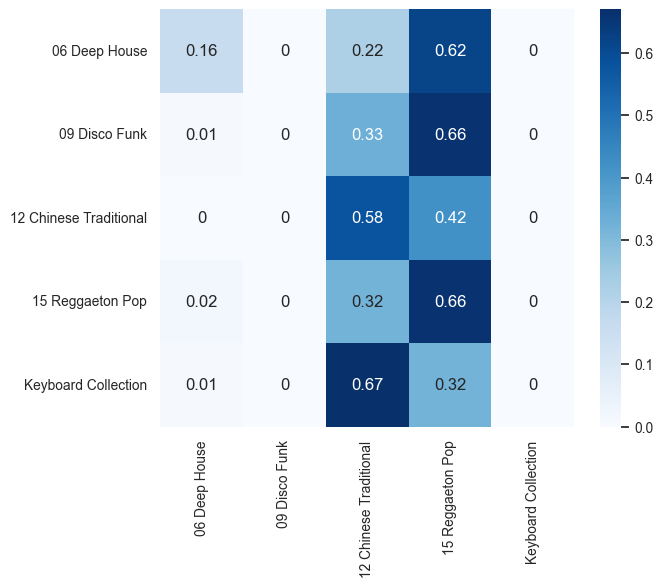

In [85]:
class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/{transformer_name}{epochs}_test_conf_mat.png")